In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import nci_eval.metrics as metrics

In [3]:
import pickle
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import sklearn.metrics as sklmetrics

In [4]:
def subsample_neg_class(y_true, y_score, desired_positive_prior):
    
    desired_size_of_neg_class = int(sum(y_true) / desired_positive_prior - sum(y_true))
    # todo rise exception if can not be achieved
    
    idx_of_pos_class = np.array(range(len(y_true)))[y_true == True]
    idx_of_neg_class = np.array(range(len(y_true)))[y_true == False]
    
    np.random.shuffle(idx_of_neg_class)
    subsampled_idx_of_neg_class = idx_of_neg_class[0:desired_size_of_neg_class]
    
    idx = np.concatenate((idx_of_pos_class, subsampled_idx_of_neg_class))
    
    return y_true[idx], y_score[idx]


In [5]:
def fprs_tprs(y_true, y_score, num_of_thresholds=100):
    
    pos_scores = np.sort(y_score[y_true])
    neg_scores = np.sort(y_score[~y_true])
    
    percentiles = np.flip(np.linspace(0.0, 100.0, num=num_of_thresholds, endpoint=False))
    ths = np.percentile(pos_scores, percentiles)
    tprs = (100.0 - percentiles) / 100.0
    
    fprs = np.empty(len(ths), 'float64')
    fps, idx_neg = 0, len(neg_scores) - 1
    for tt in range(len(ths)):
        while idx_neg >= 0 and neg_scores[idx_neg] >= ths[tt]:
            fps += 1
            idx_neg -= 1
        fprs[tt] = fps / len(neg_scores)
    
    return fprs, tprs, ths
    

In [6]:
def precision_recall(y_true, y_score, num_of_thresholds=100):
    
    pos_scores = np.sort(y_score[y_true])
    neg_scores = np.sort(y_score[~y_true])
    
    percentiles = np.flip(np.linspace(0.0, 100.0, num=num_of_thresholds, endpoint=False))
    ths = np.percentile(pos_scores, percentiles)
    recall = (100.0 - percentiles) / 100.0
    
    precision = np.empty(len(ths), 'float64')
    idx_pos, idx_neg = len(pos_scores) - 1, len(neg_scores) - 1
    tps, fps = 0, 0
    for ii in range(len(ths)):
        while idx_neg >= 0 and neg_scores[idx_neg] >= ths[ii]:
            fps += 1
            idx_neg -= 1
        while idx_pos >= 0 and pos_scores[idx_pos] >= ths[ii]:
            tps += 1
            idx_pos -= 1
        precision[ii] = tps / (tps + fps)
    
    return precision, recall, ths
    

In [7]:
def precision_recall_repeat_k_times_subsampling_on_neg_class(y_true, y_score, k, desired_positive_prior):
    
    k_precisions, k_recalls = [], []
    
    for kk in range(k):
        sub_y_true, sub_y_score = subsample_neg_class(y_true, y_score, desired_positive_prior)
        precision, recall, _ = precision_recall(sub_y_true, sub_y_score)
        k_precisions.append(precision)
        k_recalls.append(recall)
        
    return k_precisions, k_recalls
    

In [8]:
def plot_subsampling_imagenet(class_idx, desired_positive_prior=0.01, subsampling_k_repetitions=30):
    
    with open('./imagenet-val-pred-resnet50.pickle', 'rb') as file:
        L, P, C = pickle.load(file)
        
    print("https://google.com/search?q={}".format(C[class_idx]))
    
    # Labels and prediction scores
    y_true = L == class_idx
    y_score = P[:, class_idx]
    
    # Adjusted precision
    fprs, tprs, _ = fprs_tprs(y_true, y_score)
#     fprs, tprs, _ = sklmetrics.roc_curve(y_true, y_score)
    
    adjusted_precision = [metrics.precision_from_tpr_fpr(tpr, fpr, desired_positive_prior) for (tpr, fpr) in zip(tprs, fprs)]
    
    # Sub-sampling of negative class
    k_precisions, k_recalls = precision_recall_repeat_k_times_subsampling_on_neg_class(y_true, y_score, subsampling_k_repetitions, desired_positive_prior)
    
    # Plot
    stacked_k_precisions = np.stack(k_precisions, axis=0)
    precision_max = np.max(stacked_k_precisions, axis=0)
    precision_min = np.min(stacked_k_precisions, axis=0)
    precision_q_25 = np.quantile(stacked_k_precisions, 0.25, axis=0)
    precision_q_75 = np.quantile(stacked_k_precisions, 0.75, axis=0)
    
    plt.fill_between(k_recalls[0], precision_min, precision_q_25, facecolor='k', alpha=0.10, label='Sub-sampling: Min-Max')
    plt.fill_between(k_recalls[0], precision_q_25, precision_q_75, facecolor='k', alpha=0.4, label='Sub-sampling: IQR (0.25-0.75)')
    plt.fill_between(k_recalls[0], precision_q_75, precision_max, facecolor='k', alpha=0.10)
    plt.plot(tprs, adjusted_precision, c='k', label='Adjusted Precision')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.rc('font', family='serif')
    plt.rc('xtick', labelsize='x-small')
    plt.rc('ytick', labelsize='x-small')
    plt.legend()
    

https://google.com/search?q=n01687978


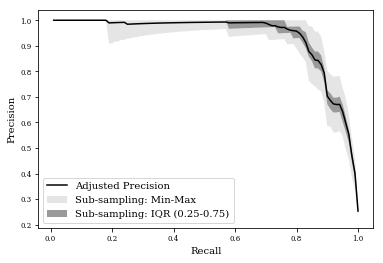

In [11]:
plot_subsampling_imagenet(class_idx=42, desired_positive_prior=0.01, subsampling_k_repetitions=100)